# LGBoost Model Training

In [ ]:
#%pip install lightgbm

In [ ]:
spark.stop()

In [1]:
# Setup Environment

import os
import logging
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRanker
import optuna
import itertools
from sklearn.preprocessing import LabelEncoder
import pyspark.sql.functions as F
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   row_number, mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment 
# Set global references to None
spark = None
master_results_df = None
df = None
training_data = None
train_df = None

In [3]:

spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()


Spark session created successfully.


In [4]:
training_data = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/train_df")

In [5]:
training_data.count()

394322

# Switching to Pandas

In [6]:
# Convert Spark DataFrame -> Pandas DataFrame

training_data = training_data.toPandas()
# Quick info about the DataFrame
#print(df.info())
#print(df.head(5))

# Set race_id

In [7]:
training_data["race_id"] = (
    training_data["course_cd"].astype(str) + "_" +
    training_data["race_date"].astype(str) + "_" +
    training_data["race_number"].astype(str)
)

# Group and sort data by race_id and group_id

In [8]:
# Generate unique numeric group_id from race_id
training_data["group_id"] = training_data["race_id"].astype("category").cat.codes

In [9]:
# Sort by race_id for consistency
training_data = training_data.sort_values("group_id", ascending=True)
training_data.reset_index(drop=True, inplace=True)

# Drop Non-numeric Features

In [10]:
unused_columns = [
    # columns you do NOT use in features or group_id
    "race_date", "date_of_birth"
]
cols_to_drop = [col for col in unused_columns if col in training_data.columns]

training_data.drop(columns=cols_to_drop, inplace=True)
print("After dropping unused cols, shape:", training_data.shape)

After dropping unused cols, shape: (394322, 78)


# Convert DataTime columns to Numerical Values

In [11]:
# Convert datetime columns to numerical
training_data["first_race_date_5"] = pd.to_datetime(training_data["first_race_date_5"])
training_data["most_recent_race_5"] = pd.to_datetime(training_data["most_recent_race_5"])
training_data["prev_race_date"] = pd.to_datetime(training_data["prev_race_date"])

# Calculate numeric date features
training_data["first_race_date_5_numeric"] = (training_data["first_race_date_5"] - pd.Timestamp("1970-01-01")).dt.days
training_data["most_recent_race_5_numeric"] = (training_data["most_recent_race_5"] - pd.Timestamp("1970-01-01")).dt.days
training_data["prev_race_date_numeric"] = (training_data["prev_race_date"] - pd.Timestamp("1970-01-01")).dt.days

# Drop original datetime columns
training_data.drop(columns=["first_race_date_5", "most_recent_race_5", "prev_race_date"], inplace=True)


# Set Rank/Label

In [12]:
# If the largest official_fin is 20 (some races can have 20 horses),
# then label = (21 - official_fin).
# So official_fin=1 => label=20, official_fin=2 =>19, etc.
# If your max is 14, you can do (15 - official_fin).  Just ensure "best" horse has largest label.
if "official_fin" in training_data.columns:
    # Calculate 'rank' and add it to the DataFrame
    training_data["rank"] = 21 - training_data["official_fin"]
    # Drop the 'official_fin' column
    training_data.drop(columns=["official_fin"], inplace=True)

# Simple Target Encoding for (XGBoost/LightGBM)

In [13]:
# MAKE SURE YOU KEEP A COPY OF THE original horse_id before encoding.
training_data["horse_id_original"] = training_data["horse_id"]

def target_encode_horse_id(df, horse_col, target_col, n_splits=5):
    """Perform K-fold target encoding for a high-cardinality column (horse_id)."""
    # Make a copy to avoid side-effects
    df_encoded = df.copy()
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    global_mean = df[target_col].mean()  # global average (fallback)
    
    df_encoded["horse_id_encoded"] = np.nan
    
    for train_idx, valid_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        valid_fold = df.iloc[valid_idx]

        # Compute the mean rank (or finishing) per horse in the train fold
        means = train_fold.groupby(horse_col)[target_col].mean()
        
        # Map onto the validation fold
        df_encoded.loc[valid_fold.index, "horse_id_encoded"] = \
            valid_fold[horse_col].map(means)
    
    # Fill any horse IDs not seen in training folds with the global mean
    df_encoded["horse_id_encoded"] = df_encoded["horse_id_encoded"].fillna(global_mean)
   
    return df_encoded

# Example usage:
training_data = target_encode_horse_id(
    df=training_data,
    horse_col="horse_id",
    target_col="rank",  # or official_finish, or a 0/1 for finishing top 3
    n_splits=5
)

# Now you have "horse_id_encoded" as a numeric column for training.
# You can drop the original horse_id (or keep it if you want to do something else later).
training_data.drop(columns=["horse_id"], inplace=True)

# Encode horse_id
training_data = target_encode_horse_id(
    df=training_data,
    horse_col="horse_id",
    target_col="rank",
    n_splits=5
)

# Drop the original horse_id
training_data.drop(columns=["horse_id"], inplace=True)

# Assigned Numerical Features

In [14]:
features = ['race_number','horse_id_encoded','purse','weight','claimprice','power','morn_odds','avgspd','class_rating',
    'net_sentiment','avg_spd_sd','ave_cl_sd','hi_spd_sd','pstyerl','all_starts','all_win','all_place',
    'all_show','all_fourth','all_earnings','cond_starts','cond_win','cond_place','cond_show','cond_fourth',
    'cond_earnings','avg_speed_5','best_speed','avg_beaten_len_5','avg_dist_bk_gate1_5','avg_dist_bk_gate2_5',
    'avg_dist_bk_gate3_5','avg_dist_bk_gate4_5','avg_speed_fullrace_5','avg_stride_length_5','avg_strfreq_q1_5',
    'avg_strfreq_q2_5','avg_strfreq_q3_5','avg_strfreq_q4_5','prev_speed','speed_improvement','days_off',
    'avg_workout_rank_3','jock_win_percent','jock_itm_percent','trainer_win_percent','trainer_itm_percent',
    'jt_win_percent','jt_itm_percent','jock_win_track','jock_itm_track','trainer_win_track','trainer_itm_track',
    'jt_win_track','jt_itm_track','age_at_race_day','distance_meters', 'count_workouts_3']

# Set the Category Columns with Label Encoder

In [26]:
# Identify categorical columns
cat_cols = ["course_cd", "sex", "equip", "surface", "med", 
            "race_type", "stk_clm_md", "turf_mud_mark", "layoff_cat"]

# Label encode categorical columns
for c in cat_cols:
    lbl = LabelEncoder()
    training_data[c] = lbl.fit_transform(training_data[c].astype(str))

    
# Specify categorical feature indices
cat_cols_indices = [training_data.columns.get_loc(col) for col in cat_cols]


# Check Horser Per Race Distribution

count    51075.000000
mean         7.720450
std          1.949667
min          2.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         20.000000
dtype: float64
2        16
3       140
4       951
5      4325
6      9693
7     10955
8      8896
9      6251
10     4837
11     2559
12     2304
13       87
14       57
17        1
18        1
20        2
Name: count, dtype: int64


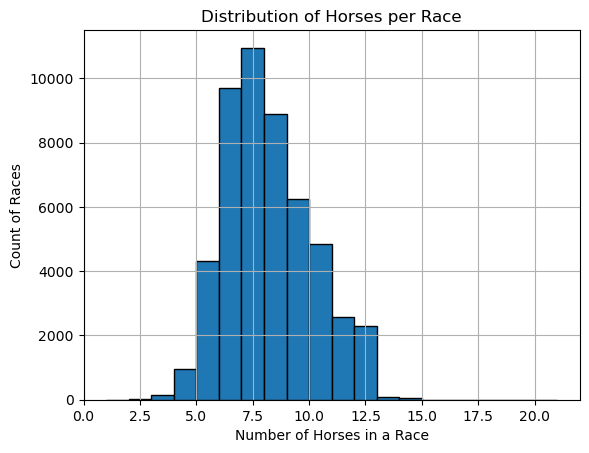

In [16]:
# 1) Count how many horses per race
counts_per_race = training_data.groupby("race_id").size()

# 2) Basic descriptive stats (mean, std, min, max, quartiles)
print(counts_per_race.describe())

# 3) Frequency table of the counts themselves (e.g., how many races had X horses)
print(counts_per_race.value_counts().sort_index())

# 4) Optional: visualize the distribution as a histogram

counts_per_race.hist(bins=range(1, counts_per_race.max() + 2), edgecolor='black')
plt.xlabel("Number of Horses in a Race")
plt.ylabel("Count of Races")
plt.title("Distribution of Horses per Race")
plt.show()

# Split Data Into Training and Validation

In [17]:
def split_train_valid(
    training_data,       # A DataFrame containing features, group_id, and target
    race_id_col,         # String name of the column that identifies the race/group
    features,            # List of feature column names
    target,              # String name of the target column
    train_ratio=0.8,
    random_state=42
):
    # 1) Shuffle the unique race IDs
    unique_races = training_data[race_id_col].unique()
    unique_races = shuffle(unique_races, random_state=random_state)

    # 2) Split into train/valid sets by race
    cut = int(len(unique_races) * train_ratio)
    train_races = set(unique_races[:cut])
    valid_races = set(unique_races[cut:])

    # 3) Boolean masks
    train_mask = training_data[race_id_col].isin(train_races)
    valid_mask = training_data[race_id_col].isin(valid_races)

    # 4) Subset data
    X_train = training_data.loc[train_mask, features]
    y_train = training_data.loc[train_mask, target]
    race_id_train = training_data.loc[train_mask, race_id_col]

    X_valid = training_data.loc[valid_mask, features]
    y_valid = training_data.loc[valid_mask, target]
    race_id_valid = training_data.loc[valid_mask, race_id_col]

    return X_train, y_train, race_id_train, X_valid, y_valid, race_id_valid

In [18]:
X_train, y_train, race_id_train, X_valid, y_valid, race_id_valid = split_train_valid(
    training_data=training_data,           # The entire DF
    race_id_col="group_id",           # The column name for group/race
    features=features,                # List of feature columns
    target="rank",                    # Name of target column
    train_ratio=0.8,
    random_state=42
)

In [19]:
# Validate groups
print("X_train shape:", X_train.shape)
print("race_id_train length:", len(race_id_train))

X_train shape: (315386, 58)
race_id_train length: 315386


In [20]:
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)
print("race_id_valid length:", len(race_id_valid))

assert len(X_valid) == len(y_valid), "Mismatch between X_valid and y_valid"
assert len(X_valid) == len(race_id_valid), "Mismatch between X_valid and group_valid"

X_valid shape: (78936, 58)
y_valid shape: (78936,)
race_id_valid length: 78936


# LGB Modeling

### Use LGBMRanker

# Hyperparameter Tuning with Optuna

In [21]:
# Convert race_id_* to 0-based integer arrays to avoid any large or negative IDs
train_group_ids = pd.factorize(race_id_train)[0]  # shape [n_train], all integers in [0..#groups-1]
valid_group_ids = pd.factorize(race_id_valid)[0]  # shape [n_valid]

# Ensure group sizes are correct
train_group_sizes = np.bincount(train_group_ids)
valid_group_sizes = np.bincount(valid_group_ids)


In [27]:
def objective(trial):
    params = {
        "boosting_type": "gbdt",
        "objective": "lambdarank",
        "metric": "ndcg",     # base metric
        "eval_at": [4],       # focusing on ndcg@4
        "n_estimators": 10_000,   # large upper bound
        "device_type": "gpu",     # or "cpu" if desired
        "verbosity": -1,          # suppress logs

        # Tuning suggestions
        "num_leaves": trial.suggest_int("num_leaves", 15, 127),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 300),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        "max_bin": trial.suggest_int("max_bin", 32, 255),
    }

    # Create LGB Datasets with categorical indices
    train_dataset = lgb.Dataset(
        X_train,
        label=y_train,
        group=train_group_sizes,
        categorical_feature=cat_cols_indices
    )
    valid_dataset = lgb.Dataset(
        X_valid,
        label=y_valid,
        group=valid_group_sizes,
        categorical_feature=cat_cols_indices,
        reference=train_dataset
    )

    # Train the model
    lgb_model = lgb.train(
        params,
        train_dataset,
        valid_sets=[train_dataset, valid_dataset],
        valid_names=["train", "valid"],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(50),         # stop if no improvement after 50 rounds
            lgb.log_evaluation(100)         # log metric every 100 iters
        ]
    )

    # Fetch the best ndcg@4 from lgb_model.best_score
    best_score_ndcg4 = lgb_model.best_score["valid"]["ndcg@4"]
    return best_score_ndcg4

def run_optuna():
    study = optuna.create_study(direction="maximize")  # we want to maximize ndcg@4
    study.optimize(objective, n_trials=100)
    return study

# Run the optimization
study = run_optuna()

best_params = study.best_params
best_value = study.best_value  # best ndcg@4
print("Best Params:", best_params)
print("Best ndcg@4:", best_value)

[I 2025-01-12 23:05:14,592] A new study created in memory with name: no-name-e2888d59-55d1-499d-a96c-1ccb2aca26a7
/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:05:35,809] Trial 0 finished with value: 0.903408289474208 and parameters: {'num_leaves': 60, 'learning_rate': 0.03113906858212685, 'feature_fraction': 0.7635313851269205, 'bagging_fraction': 0.819204346073235, 'bagging_freq': 9, 'min_data_in_leaf': 113, 'lambda_l1': 9.46387059407144, 'lambda_l2': 1.5844851316654796, 'min_gain_to_split': 0.1918094093390742, 'max_bin': 176}. Best is trial 0 with value: 0.903408289474208.


[900]	train's ndcg@4: 0.941075	valid's ndcg@4: 0.903158
Early stopping, best iteration is:
[851]	train's ndcg@4: 0.9402	valid's ndcg@4: 0.903408


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:05:49,544] Trial 1 finished with value: 0.8977174895297007 and parameters: {'num_leaves': 103, 'learning_rate': 0.04019422050907136, 'feature_fraction': 0.7431181858996759, 'bagging_fraction': 0.6294026311575127, 'bagging_freq': 8, 'min_data_in_leaf': 231, 'lambda_l1': 8.474915434037776, 'lambda_l2': 4.633319345297129, 'min_gain_to_split': 0.0790802951908296, 'max_bin': 91}. Best is trial 0 with value: 0.903408289474208.


Early stopping, best iteration is:
[344]	train's ndcg@4: 0.93385	valid's ndcg@4: 0.897717


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:06:32,299] Trial 2 finished with value: 0.8989417951386358 and parameters: {'num_leaves': 101, 'learning_rate': 0.024801739598957262, 'feature_fraction': 0.7926420697597332, 'bagging_fraction': 0.9187993848767909, 'bagging_freq': 6, 'min_data_in_leaf': 67, 'lambda_l1': 6.735879422022047, 'lambda_l2': 2.77167215994218, 'min_gain_to_split': 0.2725641216997865, 'max_bin': 120}. Best is trial 0 with value: 0.903408289474208.


Early stopping, best iteration is:
[1193]	train's ndcg@4: 0.950922	valid's ndcg@4: 0.898942


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:06:35,474] Trial 3 finished with value: 0.8894497766802688 and parameters: {'num_leaves': 56, 'learning_rate': 0.16460420129598988, 'feature_fraction': 0.7069486134568945, 'bagging_fraction': 0.6779260864630561, 'bagging_freq': 7, 'min_data_in_leaf': 125, 'lambda_l1': 6.290862229844119, 'lambda_l2': 1.3267263238098237, 'min_gain_to_split': 0.762031954535363, 'max_bin': 45}. Best is trial 0 with value: 0.903408289474208.


Early stopping, best iteration is:
[87]	train's ndcg@4: 0.9177	valid's ndcg@4: 0.88945


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:06:49,193] Trial 4 finished with value: 0.903737456289565 and parameters: {'num_leaves': 29, 'learning_rate': 0.05489883175930238, 'feature_fraction': 0.9323314297505296, 'bagging_fraction': 0.9556037140527615, 'bagging_freq': 4, 'min_data_in_leaf': 97, 'lambda_l1': 7.942384619997292, 'lambda_l2': 8.69714042914823, 'min_gain_to_split': 0.261423786242843, 'max_bin': 208}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[886]	train's ndcg@4: 0.937434	valid's ndcg@4: 0.903737


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:06:59,407] Trial 5 finished with value: 0.9016740724919873 and parameters: {'num_leaves': 39, 'learning_rate': 0.030750410298218255, 'feature_fraction': 0.8040745760132034, 'bagging_fraction': 0.6681703256205818, 'bagging_freq': 7, 'min_data_in_leaf': 60, 'lambda_l1': 4.357813748739959, 'lambda_l2': 3.3741547658104376, 'min_gain_to_split': 0.291019212742748, 'max_bin': 97}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[588]	train's ndcg@4: 0.927301	valid's ndcg@4: 0.901674


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:07:02,401] Trial 6 finished with value: 0.8966271719069215 and parameters: {'num_leaves': 24, 'learning_rate': 0.23487741762857564, 'feature_fraction': 0.7747076775691378, 'bagging_fraction': 0.7832130518512046, 'bagging_freq': 8, 'min_data_in_leaf': 213, 'lambda_l1': 8.413233344608171, 'lambda_l2': 2.393589120956835, 'min_gain_to_split': 0.31841832212387, 'max_bin': 140}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[189]	train's ndcg@4: 0.926408	valid's ndcg@4: 0.896627


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:07:21,484] Trial 7 finished with value: 0.8928901686608877 and parameters: {'num_leaves': 110, 'learning_rate': 0.06746786663169106, 'feature_fraction': 0.9905145875421044, 'bagging_fraction': 0.9056786368709131, 'bagging_freq': 2, 'min_data_in_leaf': 71, 'lambda_l1': 4.5653339899363, 'lambda_l2': 4.780388778254268, 'min_gain_to_split': 0.7877373381007805, 'max_bin': 182}. Best is trial 4 with value: 0.903737456289565.


[500]	train's ndcg@4: 0.950096	valid's ndcg@4: 0.892747
Early stopping, best iteration is:
[451]	train's ndcg@4: 0.949173	valid's ndcg@4: 0.89289


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:07:50,244] Trial 8 finished with value: 0.9019348272222223 and parameters: {'num_leaves': 67, 'learning_rate': 0.00967178715331216, 'feature_fraction': 0.7796884243948978, 'bagging_fraction': 0.7777814978143561, 'bagging_freq': 10, 'min_data_in_leaf': 120, 'lambda_l1': 1.7505082367264646, 'lambda_l2': 8.727453904434908, 'min_gain_to_split': 0.17201462284706293, 'max_bin': 74}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[1189]	train's ndcg@4: 0.929584	valid's ndcg@4: 0.901935


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:08:11,780] Trial 9 finished with value: 0.8959795474826537 and parameters: {'num_leaves': 101, 'learning_rate': 0.034279675738448784, 'feature_fraction': 0.8959556172851002, 'bagging_fraction': 0.6766032305245536, 'bagging_freq': 6, 'min_data_in_leaf': 54, 'lambda_l1': 9.237346843864447, 'lambda_l2': 5.322623209661251, 'min_gain_to_split': 0.9150489825243702, 'max_bin': 182}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[766]	train's ndcg@4: 0.939793	valid's ndcg@4: 0.89598


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:08:54,714] Trial 10 finished with value: 0.8997838617278192 and parameters: {'num_leaves': 17, 'learning_rate': 0.006051115187734101, 'feature_fraction': 0.6240622705134401, 'bagging_fraction': 0.9902005558476483, 'bagging_freq': 3, 'min_data_in_leaf': 273, 'lambda_l1': 0.2008115164938058, 'lambda_l2': 9.773941412808066, 'min_gain_to_split': 0.47770720311407505, 'max_bin': 248}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[3570]	train's ndcg@4: 0.912249	valid's ndcg@4: 0.899784


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:09:03,789] Trial 11 finished with value: 0.8995669185261174 and parameters: {'num_leaves': 48, 'learning_rate': 0.08579336382016997, 'feature_fraction': 0.8921190205259246, 'bagging_fraction': 0.8650846006548701, 'bagging_freq': 4, 'min_data_in_leaf': 152, 'lambda_l1': 9.601478791066958, 'lambda_l2': 7.197164292116371, 'min_gain_to_split': 0.5048545583330094, 'max_bin': 217}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[401]	train's ndcg@4: 0.938981	valid's ndcg@4: 0.899567


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:09:25,319] Trial 12 finished with value: 0.8986493206181368 and parameters: {'num_leaves': 83, 'learning_rate': 0.01718218116762236, 'feature_fraction': 0.9243989254460524, 'bagging_fraction': 0.5128740344191886, 'bagging_freq': 10, 'min_data_in_leaf': 110, 'lambda_l1': 6.869463814341335, 'lambda_l2': 0.23126246854706145, 'min_gain_to_split': 0.022342706812407576, 'max_bin': 180}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[638]	train's ndcg@4: 0.928934	valid's ndcg@4: 0.898649


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:09:34,440] Trial 13 finished with value: 0.9019516479563348 and parameters: {'num_leaves': 33, 'learning_rate': 0.07981796006957316, 'feature_fraction': 0.8484518581486842, 'bagging_fraction': 0.9794479123176676, 'bagging_freq': 4, 'min_data_in_leaf': 170, 'lambda_l1': 7.734395911083826, 'lambda_l2': 7.228391734151625, 'min_gain_to_split': 0.4659980390874717, 'max_bin': 216}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[515]	train's ndcg@4: 0.935926	valid's ndcg@4: 0.901952


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:10:03,193] Trial 14 finished with value: 0.9017503552203329 and parameters: {'num_leaves': 77, 'learning_rate': 0.011390966167216684, 'feature_fraction': 0.9992277554899058, 'bagging_fraction': 0.8401421395973302, 'bagging_freq': 1, 'min_data_in_leaf': 185, 'lambda_l1': 9.915958261599947, 'lambda_l2': 7.186294683994196, 'min_gain_to_split': 0.17589962269933168, 'max_bin': 255}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[1013]	train's ndcg@4: 0.930992	valid's ndcg@4: 0.90175


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:10:24,304] Trial 15 finished with value: 0.8972983197601005 and parameters: {'num_leaves': 125, 'learning_rate': 0.05291961028255382, 'feature_fraction': 0.6713561017023197, 'bagging_fraction': 0.8333138846330091, 'bagging_freq': 4, 'min_data_in_leaf': 100, 'lambda_l1': 5.650394433180978, 'lambda_l2': 0.023816497333946307, 'min_gain_to_split': 0.38993317079967416, 'max_bin': 153}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[447]	train's ndcg@4: 0.947304	valid's ndcg@4: 0.897298


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:10:31,023] Trial 16 finished with value: 0.8960896177772488 and parameters: {'num_leaves': 53, 'learning_rate': 0.12452255619734498, 'feature_fraction': 0.8478139726727036, 'bagging_fraction': 0.9356314672642905, 'bagging_freq': 9, 'min_data_in_leaf': 25, 'lambda_l1': 3.3693389024956533, 'lambda_l2': 5.877679407514794, 'min_gain_to_split': 0.5976305902289496, 'max_bin': 214}. Best is trial 4 with value: 0.903737456289565.


Early stopping, best iteration is:
[276]	train's ndcg@4: 0.94202	valid's ndcg@4: 0.89609


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:10:47,841] Trial 17 finished with value: 0.9014637865496299 and parameters: {'num_leaves': 63, 'learning_rate': 0.020126364364491826, 'feature_fraction': 0.9428553469784556, 'bagging_fraction': 0.7383909666677784, 'bagging_freq': 5, 'min_data_in_leaf': 148, 'lambda_l1': 7.949309953704106, 'lambda_l2': 9.967239150722628, 'min_gain_to_split': 0.14106308672505813, 'max_bin': 158}. Best is trial 4 with value: 0.903737456289565.
/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:10:57,665] Trial 18 finished with value: 0.9046754387350385 and parameters: {'num_leaves': 36, 'learning_rate': 0.04821972834849473, 'feature_fraction': 0.8539740292820912, 'bagging_fraction': 0.8789079578984088, 'bagging_freq': 5, 'min_data_in_leaf': 90, 'lambda_l1': 7.467623508100171, 'lambda_l2': 8.55435384125124, 'min_gain_to_split': 0.006363925888122068, 'max_bin': 200}. Best is trial 18 with value: 0.9046754387350385.


Early stopping, best iteration is:
[544]	train's ndcg@4: 0.93296	valid's ndcg@4: 0.904675


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:03,107] Trial 19 finished with value: 0.9029685985842039 and parameters: {'num_leaves': 35, 'learning_rate': 0.11254098602785095, 'feature_fraction': 0.8579119433144464, 'bagging_fraction': 0.8839343748120203, 'bagging_freq': 3, 'min_data_in_leaf': 20, 'lambda_l1': 7.386110758694502, 'lambda_l2': 8.453710411368585, 'min_gain_to_split': 0.0019575623257534177, 'max_bin': 204}. Best is trial 18 with value: 0.9046754387350385.


Early stopping, best iteration is:
[246]	train's ndcg@4: 0.931814	valid's ndcg@4: 0.902969


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:13,100] Trial 20 finished with value: 0.9049638709735989 and parameters: {'num_leaves': 24, 'learning_rate': 0.05068208859396193, 'feature_fraction': 0.9602301557936587, 'bagging_fraction': 0.964233831079896, 'bagging_freq': 5, 'min_data_in_leaf': 88, 'lambda_l1': 5.390776401614741, 'lambda_l2': 8.667524700615312, 'min_gain_to_split': 0.09836799588164244, 'max_bin': 235}. Best is trial 20 with value: 0.9049638709735989.


Early stopping, best iteration is:
[749]	train's ndcg@4: 0.932074	valid's ndcg@4: 0.904964


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:22,047] Trial 21 finished with value: 0.9061313698771415 and parameters: {'num_leaves': 16, 'learning_rate': 0.05052015493932671, 'feature_fraction': 0.9632249372822493, 'bagging_fraction': 0.9538923835631944, 'bagging_freq': 5, 'min_data_in_leaf': 94, 'lambda_l1': 5.4935898547081345, 'lambda_l2': 8.517070314514202, 'min_gain_to_split': 0.08847530352210856, 'max_bin': 237}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[798]	train's ndcg@4: 0.925067	valid's ndcg@4: 0.906131


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:33,322] Trial 22 finished with value: 0.9056065394379399 and parameters: {'num_leaves': 19, 'learning_rate': 0.04668853579750223, 'feature_fraction': 0.9748404829963745, 'bagging_fraction': 0.9930213255603719, 'bagging_freq': 5, 'min_data_in_leaf': 80, 'lambda_l1': 3.4466337644654197, 'lambda_l2': 7.845800751009602, 'min_gain_to_split': 0.09584799056431725, 'max_bin': 240}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[993]	train's ndcg@4: 0.93015	valid's ndcg@4: 0.905607


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:38,450] Trial 23 finished with value: 0.9038109983830871 and parameters: {'num_leaves': 18, 'learning_rate': 0.09493342158331468, 'feature_fraction': 0.9655860483610552, 'bagging_fraction': 0.9815957178113035, 'bagging_freq': 6, 'min_data_in_leaf': 39, 'lambda_l1': 3.2837610545299736, 'lambda_l2': 6.377363868020435, 'min_gain_to_split': 0.1185335718515225, 'max_bin': 230}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[447]	train's ndcg@4: 0.92729	valid's ndcg@4: 0.903811


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:49,772] Trial 24 finished with value: 0.901199160367895 and parameters: {'num_leaves': 44, 'learning_rate': 0.06371694013686208, 'feature_fraction': 0.9633222411874509, 'bagging_fraction': 0.9980297998654583, 'bagging_freq': 5, 'min_data_in_leaf': 81, 'lambda_l1': 3.4826051004089655, 'lambda_l2': 7.923309682100079, 'min_gain_to_split': 0.06826409612146216, 'max_bin': 239}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[541]	train's ndcg@4: 0.940547	valid's ndcg@4: 0.901199


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:11:54,696] Trial 25 finished with value: 0.9028844529621313 and parameters: {'num_leaves': 16, 'learning_rate': 0.15254905984710768, 'feature_fraction': 0.8910000398533584, 'bagging_fraction': 0.9390113948396391, 'bagging_freq': 3, 'min_data_in_leaf': 130, 'lambda_l1': 5.561183705606242, 'lambda_l2': 9.248782189154907, 'min_gain_to_split': 0.36753732691062335, 'max_bin': 231}. Best is trial 21 with value: 0.9061313698771415.
/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:12:13,247] Trial 26 finished with value: 0.9061290139855339 and parameters: {'num_leaves': 25, 'learning_rate': 0.021134838137298727, 'feature_fraction': 0.9715981520557724, 'bagging_fraction': 0.9462648380278815, 'bagging_freq': 7, 'min_data_in_leaf': 46, 'lambda_l1': 2.3159884749709585, 'lambda_l2': 7.7180507433563506, 'min_gain_to_split': 0.21759265479780293, 'max_bin': 254}. Best is trial 21 with value: 0.9061313698771415.


[1600]	train's ndcg@4: 0.931664	valid's ndcg@4: 0.905916
Early stopping, best iteration is:
[1554]	train's ndcg@4: 0.931128	valid's ndcg@4: 0.906129


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:12:27,853] Trial 27 finished with value: 0.9045705854072282 and parameters: {'num_leaves': 24, 'learning_rate': 0.015717670668131265, 'feature_fraction': 0.908630603400533, 'bagging_fraction': 0.9101361951565163, 'bagging_freq': 7, 'min_data_in_leaf': 44, 'lambda_l1': 1.9356527336134457, 'lambda_l2': 6.361317838551418, 'min_gain_to_split': 0.24508708528948317, 'max_bin': 255}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[1183]	train's ndcg@4: 0.920593	valid's ndcg@4: 0.904571


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:12:38,241] Trial 28 finished with value: 0.8997353452986642 and parameters: {'num_leaves': 47, 'learning_rate': 0.024966244803661494, 'feature_fraction': 0.9825141657721981, 'bagging_fraction': 0.5080717030708747, 'bagging_freq': 8, 'min_data_in_leaf': 139, 'lambda_l1': 1.9906905101150252, 'lambda_l2': 7.802058722212464, 'min_gain_to_split': 0.2094975118186182, 'max_bin': 224}. Best is trial 21 with value: 0.9061313698771415.


[600]	train's ndcg@4: 0.926617	valid's ndcg@4: 0.899387
Early stopping, best iteration is:
[551]	train's ndcg@4: 0.925133	valid's ndcg@4: 0.899735


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:13:02,076] Trial 29 finished with value: 0.9059084847963897 and parameters: {'num_leaves': 15, 'learning_rate': 0.012698555499365587, 'feature_fraction': 0.8256861130417111, 'bagging_fraction': 0.9487232959951146, 'bagging_freq': 7, 'min_data_in_leaf': 35, 'lambda_l1': 0.9549837095779399, 'lambda_l2': 4.16312105317178, 'min_gain_to_split': 0.35685679059624964, 'max_bin': 194}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[2849]	train's ndcg@4: 0.922497	valid's ndcg@4: 0.905908


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:13:39,106] Trial 30 finished with value: 0.9038696906671854 and parameters: {'num_leaves': 27, 'learning_rate': 0.005603457536402246, 'feature_fraction': 0.827619024676809, 'bagging_fraction': 0.8031832845350826, 'bagging_freq': 7, 'min_data_in_leaf': 43, 'lambda_l1': 0.30082761883249454, 'lambda_l2': 3.9924510032825777, 'min_gain_to_split': 0.5935186499146975, 'max_bin': 195}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[2943]	train's ndcg@4: 0.921116	valid's ndcg@4: 0.90387


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:14:02,175] Trial 31 finished with value: 0.904409714927889 and parameters: {'num_leaves': 16, 'learning_rate': 0.011434864468505454, 'feature_fraction': 0.9311719062720097, 'bagging_fraction': 0.9483931816034524, 'bagging_freq': 6, 'min_data_in_leaf': 70, 'lambda_l1': 0.8903306570344731, 'lambda_l2': 6.495374959296546, 'min_gain_to_split': 0.38329222232906884, 'max_bin': 242}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[2483]	train's ndcg@4: 0.919043	valid's ndcg@4: 0.90441


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:14:23,980] Trial 32 finished with value: 0.9027289643866103 and parameters: {'num_leaves': 28, 'learning_rate': 0.007873363779592135, 'feature_fraction': 0.9652928161955158, 'bagging_fraction': 0.8972485535548598, 'bagging_freq': 9, 'min_data_in_leaf': 36, 'lambda_l1': 2.435541058224876, 'lambda_l2': 5.531892313424507, 'min_gain_to_split': 0.20294307648112342, 'max_bin': 167}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[1631]	train's ndcg@4: 0.916927	valid's ndcg@4: 0.902729


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:14:33,730] Trial 33 finished with value: 0.905566910354832 and parameters: {'num_leaves': 41, 'learning_rate': 0.038567759961208405, 'feature_fraction': 0.747580170830871, 'bagging_fraction': 0.8564556383042385, 'bagging_freq': 6, 'min_data_in_leaf': 58, 'lambda_l1': 1.1596926191923442, 'lambda_l2': 7.741473351232737, 'min_gain_to_split': 0.07898852928871564, 'max_bin': 191}. Best is trial 21 with value: 0.9061313698771415.


Early stopping, best iteration is:
[515]	train's ndcg@4: 0.931529	valid's ndcg@4: 0.905567


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:14:47,633] Trial 34 finished with value: 0.906877764041659 and parameters: {'num_leaves': 15, 'learning_rate': 0.026023305879456993, 'feature_fraction': 0.9500368579763288, 'bagging_fraction': 0.9263513209035328, 'bagging_freq': 8, 'min_data_in_leaf': 78, 'lambda_l1': 2.75667396399641, 'lambda_l2': 4.108186457011682, 'min_gain_to_split': 0.33178328287961867, 'max_bin': 130}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1686]	train's ndcg@4: 0.926281	valid's ndcg@4: 0.906878


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:15:07,212] Trial 35 finished with value: 0.9053149641727705 and parameters: {'num_leaves': 32, 'learning_rate': 0.025860516993919568, 'feature_fraction': 0.7118988262930651, 'bagging_fraction': 0.9287062589247015, 'bagging_freq': 8, 'min_data_in_leaf': 106, 'lambda_l1': 2.612489472438315, 'lambda_l2': 4.323056724843201, 'min_gain_to_split': 0.31871923489107956, 'max_bin': 123}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1367]	train's ndcg@4: 0.936076	valid's ndcg@4: 0.905315


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:15:23,324] Trial 36 finished with value: 0.903255909367025 and parameters: {'num_leaves': 15, 'learning_rate': 0.015238320987698796, 'feature_fraction': 0.8769087215215396, 'bagging_fraction': 0.7243496234540489, 'bagging_freq': 7, 'min_data_in_leaf': 56, 'lambda_l1': 4.373450506531004, 'lambda_l2': 3.415964237984615, 'min_gain_to_split': 0.43364111689136964, 'max_bin': 122}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1903]	train's ndcg@4: 0.918763	valid's ndcg@4: 0.903256


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:15:46,314] Trial 37 finished with value: 0.9053753112109593 and parameters: {'num_leaves': 22, 'learning_rate': 0.018781725717379388, 'feature_fraction': 0.9436069743242158, 'bagging_fraction': 0.957721786505117, 'bagging_freq': 8, 'min_data_in_leaf': 20, 'lambda_l1': 1.1437173590656275, 'lambda_l2': 2.748622526872488, 'min_gain_to_split': 0.564899192335873, 'max_bin': 102}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[2112]	train's ndcg@4: 0.931195	valid's ndcg@4: 0.905375


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:15:56,558] Trial 38 finished with value: 0.9021237894287153 and parameters: {'num_leaves': 29, 'learning_rate': 0.026756251446366702, 'feature_fraction': 0.9150726195683322, 'bagging_fraction': 0.5691964140223602, 'bagging_freq': 9, 'min_data_in_leaf': 75, 'lambda_l1': 2.620860785481899, 'lambda_l2': 4.227652634969694, 'min_gain_to_split': 0.2680239016855542, 'max_bin': 144}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[794]	train's ndcg@4: 0.925045	valid's ndcg@4: 0.902124


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:16:42,513] Trial 39 finished with value: 0.8976631078708234 and parameters: {'num_leaves': 91, 'learning_rate': 0.012567683153582115, 'feature_fraction': 0.8078386326802257, 'bagging_fraction': 0.9203329113758935, 'bagging_freq': 7, 'min_data_in_leaf': 200, 'lambda_l1': 3.9340593462472273, 'lambda_l2': 3.7186664717946067, 'min_gain_to_split': 0.3384400764258334, 'max_bin': 168}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1300]	train's ndcg@4: 0.939881	valid's ndcg@4: 0.897663


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:16:52,714] Trial 40 finished with value: 0.902428378383334 and parameters: {'num_leaves': 56, 'learning_rate': 0.03178937745106336, 'feature_fraction': 0.9427980326744962, 'bagging_fraction': 0.8193362082252087, 'bagging_freq': 8, 'min_data_in_leaf': 239, 'lambda_l1': 4.881448486247548, 'lambda_l2': 2.106817777603427, 'min_gain_to_split': 0.22556130534475613, 'max_bin': 60}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[421]	train's ndcg@4: 0.929382	valid's ndcg@4: 0.902428


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:17:06,008] Trial 41 finished with value: 0.9046735017657268 and parameters: {'num_leaves': 21, 'learning_rate': 0.022014690248743862, 'feature_fraction': 0.9775866726745182, 'bagging_fraction': 0.9679834736578504, 'bagging_freq': 7, 'min_data_in_leaf': 66, 'lambda_l1': 3.0489271702532355, 'lambda_l2': 4.700711679297874, 'min_gain_to_split': 0.14410960233265735, 'max_bin': 109}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1198]	train's ndcg@4: 0.92367	valid's ndcg@4: 0.904674


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:17:19,381] Trial 42 finished with value: 0.9053957407638114 and parameters: {'num_leaves': 22, 'learning_rate': 0.038598746601240116, 'feature_fraction': 0.999856122784657, 'bagging_fraction': 0.9958473573781337, 'bagging_freq': 6, 'min_data_in_leaf': 81, 'lambda_l1': 3.9137304613541937, 'lambda_l2': 4.988958619213966, 'min_gain_to_split': 0.2873467657327976, 'max_bin': 135}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1074]	train's ndcg@4: 0.930893	valid's ndcg@4: 0.905396


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:17:28,825] Trial 43 finished with value: 0.9067195363316167 and parameters: {'num_leaves': 29, 'learning_rate': 0.04347848979118542, 'feature_fraction': 0.9511886576412355, 'bagging_fraction': 0.8973550718662459, 'bagging_freq': 5, 'min_data_in_leaf': 50, 'lambda_l1': 1.648466253240403, 'lambda_l2': 9.270408941179758, 'min_gain_to_split': 0.05444643302370019, 'max_bin': 245}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[620]	train's ndcg@4: 0.930922	valid's ndcg@4: 0.90672


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:17:41,045] Trial 44 finished with value: 0.9066725744197476 and parameters: {'num_leaves': 38, 'learning_rate': 0.03416917846874841, 'feature_fraction': 0.8753091596534962, 'bagging_fraction': 0.8990161703937509, 'bagging_freq': 8, 'min_data_in_leaf': 49, 'lambda_l1': 0.579604690556055, 'lambda_l2': 9.234050565100556, 'min_gain_to_split': 0.1598155915044722, 'max_bin': 225}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[720]	train's ndcg@4: 0.935081	valid's ndcg@4: 0.906673


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:17:49,754] Trial 45 finished with value: 0.9060617226686994 and parameters: {'num_leaves': 38, 'learning_rate': 0.06604619628230025, 'feature_fraction': 0.8772591118106516, 'bagging_fraction': 0.8922022736620505, 'bagging_freq': 9, 'min_data_in_leaf': 53, 'lambda_l1': 0.5697767748378215, 'lambda_l2': 9.330532320454179, 'min_gain_to_split': 0.057690147684333115, 'max_bin': 227}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[495]	train's ndcg@4: 0.939642	valid's ndcg@4: 0.906062


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:18:01,512] Trial 46 finished with value: 0.9055035047692976 and parameters: {'num_leaves': 28, 'learning_rate': 0.02987179055864643, 'feature_fraction': 0.9465188190297305, 'bagging_fraction': 0.863444934159525, 'bagging_freq': 4, 'min_data_in_leaf': 93, 'lambda_l1': 1.5398054273045885, 'lambda_l2': 9.253803086354866, 'min_gain_to_split': 0.16775463048034986, 'max_bin': 80}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[786]	train's ndcg@4: 0.928387	valid's ndcg@4: 0.905504


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:18:10,412] Trial 47 finished with value: 0.9046050694867063 and parameters: {'num_leaves': 32, 'learning_rate': 0.03952549452588608, 'feature_fraction': 0.9114635671560266, 'bagging_fraction': 0.7728545827553707, 'bagging_freq': 10, 'min_data_in_leaf': 119, 'lambda_l1': 6.054812925339481, 'lambda_l2': 9.144782606633346, 'min_gain_to_split': 0.05098440170921875, 'max_bin': 254}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[620]	train's ndcg@4: 0.929635	valid's ndcg@4: 0.904605


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:18:32,843] Trial 48 finished with value: 0.9013025160557344 and parameters: {'num_leaves': 44, 'learning_rate': 0.02243135929662466, 'feature_fraction': 0.9248244427842481, 'bagging_fraction': 0.9252490587595403, 'bagging_freq': 8, 'min_data_in_leaf': 49, 'lambda_l1': 1.4954782934037016, 'lambda_l2': 9.565880200998292, 'min_gain_to_split': 0.9725420181324714, 'max_bin': 245}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[1174]	train's ndcg@4: 0.935509	valid's ndcg@4: 0.901303


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:18:35,222] Trial 49 finished with value: 0.8892025173041904 and parameters: {'num_leaves': 53, 'learning_rate': 0.25601808025687206, 'feature_fraction': 0.8997350625216836, 'bagging_fraction': 0.6438297497459403, 'bagging_freq': 6, 'min_data_in_leaf': 32, 'lambda_l1': 2.3269725379453123, 'lambda_l2': 8.144896017615412, 'min_gain_to_split': 0.1434515414178924, 'max_bin': 222}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[49]	train's ndcg@4: 0.914336	valid's ndcg@4: 0.889203


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:18:56,573] Trial 50 finished with value: 0.89655580211242 and parameters: {'num_leaves': 71, 'learning_rate': 0.030377857882279417, 'feature_fraction': 0.9521315104021433, 'bagging_fraction': 0.9121414720499493, 'bagging_freq': 4, 'min_data_in_leaf': 62, 'lambda_l1': 6.381290509324851, 'lambda_l2': 8.86258977213361, 'min_gain_to_split': 0.6933702178328702, 'max_bin': 209}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[709]	train's ndcg@4: 0.937363	valid's ndcg@4: 0.896556


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:03,766] Trial 51 finished with value: 0.9058817641334717 and parameters: {'num_leaves': 39, 'learning_rate': 0.06442015658954958, 'feature_fraction': 0.8791965532109693, 'bagging_fraction': 0.8847021971502885, 'bagging_freq': 9, 'min_data_in_leaf': 69, 'lambda_l1': 0.002896206142625979, 'lambda_l2': 9.777586126026083, 'min_gain_to_split': 0.047846290527833825, 'max_bin': 228}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[378]	train's ndcg@4: 0.934424	valid's ndcg@4: 0.905882


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:10,144] Trial 52 finished with value: 0.9061555959247792 and parameters: {'num_leaves': 36, 'learning_rate': 0.07423706985108257, 'feature_fraction': 0.8679276369703509, 'bagging_fraction': 0.8967440904833254, 'bagging_freq': 9, 'min_data_in_leaf': 51, 'lambda_l1': 0.7334325496215399, 'lambda_l2': 9.485688317971713, 'min_gain_to_split': 0.11862087997470128, 'max_bin': 248}. Best is trial 34 with value: 0.906877764041659.


[400]	train's ndcg@4: 0.936472	valid's ndcg@4: 0.905608
Early stopping, best iteration is:
[351]	train's ndcg@4: 0.934256	valid's ndcg@4: 0.906156


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:16,339] Trial 53 finished with value: 0.9048200809498145 and parameters: {'num_leaves': 33, 'learning_rate': 0.07774795609269104, 'feature_fraction': 0.9878163329889378, 'bagging_fraction': 0.8496093840328222, 'bagging_freq': 10, 'min_data_in_leaf': 48, 'lambda_l1': 0.552218673345324, 'lambda_l2': 8.29933315149393, 'min_gain_to_split': 0.17226850997427656, 'max_bin': 248}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[344]	train's ndcg@4: 0.93313	valid's ndcg@4: 0.90482


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:26,367] Trial 54 finished with value: 0.901934427928801 and parameters: {'num_leaves': 26, 'learning_rate': 0.043722889331019366, 'feature_fraction': 0.9308803208496326, 'bagging_fraction': 0.8705704632011002, 'bagging_freq': 8, 'min_data_in_leaf': 98, 'lambda_l1': 1.3209695525254639, 'lambda_l2': 7.245335541784064, 'min_gain_to_split': 0.23739344627133901, 'max_bin': 38}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[729]	train's ndcg@4: 0.92824	valid's ndcg@4: 0.901934


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:33,002] Trial 55 finished with value: 0.9058865525437135 and parameters: {'num_leaves': 22, 'learning_rate': 0.05440325033152523, 'feature_fraction': 0.867468918155905, 'bagging_fraction': 0.9109967445593039, 'bagging_freq': 9, 'min_data_in_leaf': 60, 'lambda_l1': 2.093880031064433, 'lambda_l2': 8.896466622301533, 'min_gain_to_split': 0.12371461704285475, 'max_bin': 246}. Best is trial 34 with value: 0.906877764041659.


[600]	train's ndcg@4: 0.928427	valid's ndcg@4: 0.90577
Early stopping, best iteration is:
[564]	train's ndcg@4: 0.927318	valid's ndcg@4: 0.905887


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:38,030] Trial 56 finished with value: 0.9025131288478379 and parameters: {'num_leaves': 32, 'learning_rate': 0.09273496386801824, 'feature_fraction': 0.7724041581127558, 'bagging_fraction': 0.8301582360597907, 'bagging_freq': 5, 'min_data_in_leaf': 31, 'lambda_l1': 2.895158093450336, 'lambda_l2': 9.561623706131083, 'min_gain_to_split': 0.034953367402136275, 'max_bin': 214}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[273]	train's ndcg@4: 0.929433	valid's ndcg@4: 0.902513


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:19:53,669] Trial 57 finished with value: 0.9042328257040978 and parameters: {'num_leaves': 50, 'learning_rate': 0.03650914373733304, 'feature_fraction': 0.8402310171994087, 'bagging_fraction': 0.9725839188162664, 'bagging_freq': 8, 'min_data_in_leaf': 169, 'lambda_l1': 0.788967592624078, 'lambda_l2': 9.91142772318005, 'min_gain_to_split': 0.10534581569147605, 'max_bin': 240}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[709]	train's ndcg@4: 0.94056	valid's ndcg@4: 0.904233


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:01,293] Trial 58 finished with value: 0.8911019708242933 and parameters: {'num_leaves': 114, 'learning_rate': 0.19408794588293876, 'feature_fraction': 0.7931270381995623, 'bagging_fraction': 0.9375384586969325, 'bagging_freq': 9, 'min_data_in_leaf': 286, 'lambda_l1': 1.544160647022582, 'lambda_l2': 7.477917953165174, 'min_gain_to_split': 0.19610228380593914, 'max_bin': 234}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[129]	train's ndcg@4: 0.951901	valid's ndcg@4: 0.891102


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:09,532] Trial 59 finished with value: 0.9052558028813322 and parameters: {'num_leaves': 43, 'learning_rate': 0.05870879795783524, 'feature_fraction': 0.976072421794266, 'bagging_fraction': 0.8877096472635417, 'bagging_freq': 7, 'min_data_in_leaf': 107, 'lambda_l1': 0.44016968660343947, 'lambda_l2': 8.867676774087798, 'min_gain_to_split': 0.28154501351729894, 'max_bin': 130}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[396]	train's ndcg@4: 0.936679	valid's ndcg@4: 0.905256


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:18,915] Trial 60 finished with value: 0.9050112764016275 and parameters: {'num_leaves': 19, 'learning_rate': 0.04417927595665745, 'feature_fraction': 0.8975539623885768, 'bagging_fraction': 0.8024424110694884, 'bagging_freq': 5, 'min_data_in_leaf': 46, 'lambda_l1': 4.78103766407113, 'lambda_l2': 8.220431800432355, 'min_gain_to_split': 0.16328656712904352, 'max_bin': 254}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[797]	train's ndcg@4: 0.926605	valid's ndcg@4: 0.905011


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:25,924] Trial 61 finished with value: 0.9051884033977905 and parameters: {'num_leaves': 38, 'learning_rate': 0.0733796033725433, 'feature_fraction': 0.8790734552872963, 'bagging_fraction': 0.90298526982262, 'bagging_freq': 10, 'min_data_in_leaf': 53, 'lambda_l1': 0.593342682649084, 'lambda_l2': 9.413800118115352, 'min_gain_to_split': 0.07279810282400978, 'max_bin': 221}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[373]	train's ndcg@4: 0.936161	valid's ndcg@4: 0.905188


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:34,933] Trial 62 finished with value: 0.90634099208075 and parameters: {'num_leaves': 36, 'learning_rate': 0.05628506013297518, 'feature_fraction': 0.8619145133883548, 'bagging_fraction': 0.8949443477592175, 'bagging_freq': 9, 'min_data_in_leaf': 86, 'lambda_l1': 1.6942762007638954, 'lambda_l2': 9.088578736323074, 'min_gain_to_split': 0.0023631133332852466, 'max_bin': 227}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[533]	train's ndcg@4: 0.936672	valid's ndcg@4: 0.906341


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:41,982] Trial 63 finished with value: 0.9038102566205165 and parameters: {'num_leaves': 61, 'learning_rate': 0.1044355712325747, 'feature_fraction': 0.9560687998183666, 'bagging_fraction': 0.9520434430351372, 'bagging_freq': 8, 'min_data_in_leaf': 88, 'lambda_l1': 1.7360292373166897, 'lambda_l2': 8.508000707368074, 'min_gain_to_split': 0.008643385588798097, 'max_bin': 236}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[247]	train's ndcg@4: 0.944938	valid's ndcg@4: 0.90381


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:20:50,095] Trial 64 finished with value: 0.9051980584207202 and parameters: {'num_leaves': 35, 'learning_rate': 0.05655526343260983, 'feature_fraction': 0.8159823727336496, 'bagging_fraction': 0.8716630230315073, 'bagging_freq': 9, 'min_data_in_leaf': 77, 'lambda_l1': 5.231615326582302, 'lambda_l2': 6.773617477325763, 'min_gain_to_split': 0.10401718236409202, 'max_bin': 206}. Best is trial 34 with value: 0.906877764041659.


Early stopping, best iteration is:
[494]	train's ndcg@4: 0.93386	valid's ndcg@4: 0.905198


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:00,108] Trial 65 finished with value: 0.9071356788675866 and parameters: {'num_leaves': 30, 'learning_rate': 0.03189113728764088, 'feature_fraction': 0.9104069825952018, 'bagging_fraction': 0.9244972879442663, 'bagging_freq': 1, 'min_data_in_leaf': 127, 'lambda_l1': 2.1749474088107057, 'lambda_l2': 9.083695872105535, 'min_gain_to_split': 0.026341576383469373, 'max_bin': 245}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[764]	train's ndcg@4: 0.929989	valid's ndcg@4: 0.907136


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:11,080] Trial 66 finished with value: 0.9045802556031296 and parameters: {'num_leaves': 48, 'learning_rate': 0.033134995834297076, 'feature_fraction': 0.9150984578650583, 'bagging_fraction': 0.7113565286549769, 'bagging_freq': 1, 'min_data_in_leaf': 116, 'lambda_l1': 0.036291731216219536, 'lambda_l2': 8.976732603983498, 'min_gain_to_split': 0.036479985677560736, 'max_bin': 149}. Best is trial 65 with value: 0.9071356788675866.


[600]	train's ndcg@4: 0.935359	valid's ndcg@4: 0.90401
Early stopping, best iteration is:
[557]	train's ndcg@4: 0.933969	valid's ndcg@4: 0.90458


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:24,652] Trial 67 finished with value: 0.9056572613173512 and parameters: {'num_leaves': 30, 'learning_rate': 0.04846693544314125, 'feature_fraction': 0.6125152322343097, 'bagging_fraction': 0.8487755873843764, 'bagging_freq': 3, 'min_data_in_leaf': 141, 'lambda_l1': 1.8171583214667009, 'lambda_l2': 9.607903652182253, 'min_gain_to_split': 0.020534576942028267, 'max_bin': 214}. Best is trial 65 with value: 0.9071356788675866.
/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:30,968] Trial 68 finished with value: 0.9033478296245124 and parameters: {'num_leaves': 36, 'learning_rate': 0.1316331862601206, 'feature_fraction': 0.8657929093071374, 'bagging_fraction': 0.926979922308164, 'bagging_freq': 2, 'min_data_in_leaf': 102, 'lambda_l1': 1.1480987660750144, 'lambda_l2': 1.0827238605660474, 'min_gain_to_split': 0.08999688883822067, 'max_bin': 231}. Best is trial 65 with value: 0.9071356788675866.


[300]	train's ndcg@4: 0.942219	valid's ndcg@4: 0.902826
Early stopping, best iteration is:
[253]	train's ndcg@4: 0.938651	valid's ndcg@4: 0.903348


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:44,081] Trial 69 finished with value: 0.9052041352857084 and parameters: {'num_leaves': 25, 'learning_rate': 0.02815530033444047, 'feature_fraction': 0.891822899139319, 'bagging_fraction': 0.9806988649473364, 'bagging_freq': 1, 'min_data_in_leaf': 126, 'lambda_l1': 3.8346828570868294, 'lambda_l2': 8.618302085408535, 'min_gain_to_split': 0.1279704706271695, 'max_bin': 247}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[1234]	train's ndcg@4: 0.930327	valid's ndcg@4: 0.905204


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:21:57,666] Trial 70 finished with value: 0.9067057268647037 and parameters: {'num_leaves': 41, 'learning_rate': 0.03558378446261548, 'feature_fraction': 0.937688965486615, 'bagging_fraction': 0.9033581336369743, 'bagging_freq': 3, 'min_data_in_leaf': 155, 'lambda_l1': 2.0891746255497745, 'lambda_l2': 9.970103118688108, 'min_gain_to_split': 0.07586642865052781, 'max_bin': 187}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[643]	train's ndcg@4: 0.935339	valid's ndcg@4: 0.906706


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:22:12,831] Trial 71 finished with value: 0.9062247202085556 and parameters: {'num_leaves': 40, 'learning_rate': 0.034593567109096626, 'feature_fraction': 0.8373040160053691, 'bagging_fraction': 0.8993382312602218, 'bagging_freq': 2, 'min_data_in_leaf': 168, 'lambda_l1': 2.1165134508898005, 'lambda_l2': 9.108055133543505, 'min_gain_to_split': 0.06629602545975653, 'max_bin': 189}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[648]	train's ndcg@4: 0.933883	valid's ndcg@4: 0.906225


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:22:28,026] Trial 72 finished with value: 0.9057486832283133 and parameters: {'num_leaves': 41, 'learning_rate': 0.034625769913514015, 'feature_fraction': 0.8427758172039134, 'bagging_fraction': 0.8985345051662231, 'bagging_freq': 2, 'min_data_in_leaf': 160, 'lambda_l1': 2.75220340600502, 'lambda_l2': 9.645798430075105, 'min_gain_to_split': 0.0031810429628840557, 'max_bin': 175}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[600]	train's ndcg@4: 0.932713	valid's ndcg@4: 0.905749


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:22:39,905] Trial 73 finished with value: 0.9051226416170532 and parameters: {'num_leaves': 44, 'learning_rate': 0.043931800596779265, 'feature_fraction': 0.8320943420350209, 'bagging_fraction': 0.8834025159081749, 'bagging_freq': 2, 'min_data_in_leaf': 173, 'lambda_l1': 2.124679978130542, 'lambda_l2': 9.980147734206774, 'min_gain_to_split': 0.05280382248929237, 'max_bin': 201}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[464]	train's ndcg@4: 0.933452	valid's ndcg@4: 0.905123


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:22:54,790] Trial 74 finished with value: 0.9055391719514372 and parameters: {'num_leaves': 56, 'learning_rate': 0.023763843053999704, 'feature_fraction': 0.8609684371448637, 'bagging_fraction': 0.9181419823038026, 'bagging_freq': 1, 'min_data_in_leaf': 189, 'lambda_l1': 1.71242888378936, 'lambda_l2': 9.138096176370576, 'min_gain_to_split': 0.08334165044343392, 'max_bin': 187}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[667]	train's ndcg@4: 0.934692	valid's ndcg@4: 0.905539


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:23:06,280] Trial 75 finished with value: 0.9032851223537698 and parameters: {'num_leaves': 41, 'learning_rate': 0.035201879076667025, 'feature_fraction': 0.8530156732699612, 'bagging_fraction': 0.8415988307823221, 'bagging_freq': 2, 'min_data_in_leaf': 185, 'lambda_l1': 2.265796265925854, 'lambda_l2': 9.400154144023928, 'min_gain_to_split': 0.4276888747438363, 'max_bin': 158}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[471]	train's ndcg@4: 0.928074	valid's ndcg@4: 0.903285


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:23:26,386] Trial 76 finished with value: 0.9063649735982025 and parameters: {'num_leaves': 47, 'learning_rate': 0.027868726418061717, 'feature_fraction': 0.9187612137890373, 'bagging_fraction': 0.8604010133043312, 'bagging_freq': 3, 'min_data_in_leaf': 152, 'lambda_l1': 3.1173756802416124, 'lambda_l2': 9.10012711644766, 'min_gain_to_split': 0.027284478090224638, 'max_bin': 114}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[809]	train's ndcg@4: 0.937361	valid's ndcg@4: 0.906365


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:23:49,689] Trial 77 finished with value: 0.9057886882290583 and parameters: {'num_leaves': 51, 'learning_rate': 0.017643893121943314, 'feature_fraction': 0.9243514711524025, 'bagging_fraction': 0.8631883561435701, 'bagging_freq': 3, 'min_data_in_leaf': 136, 'lambda_l1': 2.944992599818312, 'lambda_l2': 8.013293717310146, 'min_gain_to_split': 0.0292403674898267, 'max_bin': 107}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[987]	train's ndcg@4: 0.934249	valid's ndcg@4: 0.905789


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:24:04,342] Trial 78 finished with value: 0.9053091041350811 and parameters: {'num_leaves': 45, 'learning_rate': 0.026671758452577982, 'feature_fraction': 0.9383946299263735, 'bagging_fraction': 0.8729418226228336, 'bagging_freq': 2, 'min_data_in_leaf': 152, 'lambda_l1': 3.12027599311838, 'lambda_l2': 9.001289992677489, 'min_gain_to_split': 0.07460540275990295, 'max_bin': 130}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[593]	train's ndcg@4: 0.930084	valid's ndcg@4: 0.905309


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:24:15,037] Trial 79 finished with value: 0.9063142112580754 and parameters: {'num_leaves': 30, 'learning_rate': 0.04132617508639465, 'feature_fraction': 0.9106741901441975, 'bagging_fraction': 0.93510207519823, 'bagging_freq': 3, 'min_data_in_leaf': 162, 'lambda_l1': 2.5960355934143715, 'lambda_l2': 8.360127138250864, 'min_gain_to_split': 0.005343793934329141, 'max_bin': 114}. Best is trial 65 with value: 0.9071356788675866.


Early stopping, best iteration is:
[601]	train's ndcg@4: 0.930224	valid's ndcg@4: 0.906314


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:24:28,625] Trial 80 finished with value: 0.9070839094560363 and parameters: {'num_leaves': 34, 'learning_rate': 0.04165095513601545, 'feature_fraction': 0.9049683657853415, 'bagging_fraction': 0.9402049804671162, 'bagging_freq': 3, 'min_data_in_leaf': 149, 'lambda_l1': 3.576571383601607, 'lambda_l2': 8.381003875384714, 'min_gain_to_split': 0.00910992334899742, 'max_bin': 114}. Best is trial 65 with value: 0.9071356788675866.
/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:24:42,228] Trial 81 finished with value: 0.907626649957541 and parameters: {'num_leaves': 31, 'learning_rate': 0.04057476221309973, 'feature_fraction': 0.9065240187156206, 'bagging_fraction': 0.9398037324878721, 'bagging_freq': 3, 'min_data_in_leaf': 157, 'lambda_l1': 3.6268667163251456, 'lambda_l2': 8.585620110362253, 'min_gain_to_split': 0.012760096984953003, 'max_bin': 113}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[792]	train's ndcg@4: 0.934833	valid's ndcg@4: 0.907627


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:25:05,193] Trial 82 finished with value: 0.9053720144447021 and parameters: {'num_leaves': 81, 'learning_rate': 0.029385626319349704, 'feature_fraction': 0.9234303706203771, 'bagging_fraction': 0.9398318483912433, 'bagging_freq': 3, 'min_data_in_leaf': 148, 'lambda_l1': 3.6135781897837376, 'lambda_l2': 8.703500442933807, 'min_gain_to_split': 0.0302565789966051, 'max_bin': 86}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[668]	train's ndcg@4: 0.945588	valid's ndcg@4: 0.905372


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:25:14,381] Trial 83 finished with value: 0.9069991352900777 and parameters: {'num_leaves': 36, 'learning_rate': 0.04859883750601119, 'feature_fraction': 0.9057748474609438, 'bagging_fraction': 0.9600078302054134, 'bagging_freq': 4, 'min_data_in_leaf': 132, 'lambda_l1': 3.241390304662933, 'lambda_l2': 3.2253111120628053, 'min_gain_to_split': 7.135508271871593e-05, 'max_bin': 120}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[498]	train's ndcg@4: 0.933606	valid's ndcg@4: 0.906999


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:25:33,736] Trial 84 finished with value: 0.9066344115463045 and parameters: {'num_leaves': 30, 'learning_rate': 0.019778177128636772, 'feature_fraction': 0.9017548266900104, 'bagging_fraction': 0.9574681131984303, 'bagging_freq': 4, 'min_data_in_leaf': 132, 'lambda_l1': 4.276654005835676, 'lambda_l2': 2.796870977807213, 'min_gain_to_split': 0.04928914747544284, 'max_bin': 95}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[1174]	train's ndcg@4: 0.929176	valid's ndcg@4: 0.906634


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:25:53,352] Trial 85 finished with value: 0.9048118005800099 and parameters: {'num_leaves': 30, 'learning_rate': 0.023759727394463304, 'feature_fraction': 0.905446438605162, 'bagging_fraction': 0.9640515361118228, 'bagging_freq': 4, 'min_data_in_leaf': 130, 'lambda_l1': 4.147413753744199, 'lambda_l2': 3.0455622525236006, 'min_gain_to_split': 0.14576903366511984, 'max_bin': 100}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[1272]	train's ndcg@4: 0.932245	valid's ndcg@4: 0.904812


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:26:12,230] Trial 86 finished with value: 0.9033605872890396 and parameters: {'num_leaves': 20, 'learning_rate': 0.015063568983990992, 'feature_fraction': 0.8905940961009434, 'bagging_fraction': 0.986608012596911, 'bagging_freq': 4, 'min_data_in_leaf': 141, 'lambda_l1': 4.560328558506938, 'lambda_l2': 3.098163207162114, 'min_gain_to_split': 0.05108754448842679, 'max_bin': 92}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[1570]	train's ndcg@4: 0.919292	valid's ndcg@4: 0.903361


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:26:22,871] Trial 87 finished with value: 0.9062437316503514 and parameters: {'num_leaves': 27, 'learning_rate': 0.05001725200040818, 'feature_fraction': 0.9360538843598973, 'bagging_fraction': 0.9619342027717278, 'bagging_freq': 4, 'min_data_in_leaf': 176, 'lambda_l1': 3.6349904214819238, 'lambda_l2': 2.1579073369376003, 'min_gain_to_split': 0.0968197448165965, 'max_bin': 127}. Best is trial 81 with value: 0.907626649957541.


[700]	train's ndcg@4: 0.934153	valid's ndcg@4: 0.90581
Early stopping, best iteration is:
[651]	train's ndcg@4: 0.932921	valid's ndcg@4: 0.906244


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:26:36,118] Trial 88 finished with value: 0.9023854040087114 and parameters: {'num_leaves': 33, 'learning_rate': 0.03977110989979568, 'feature_fraction': 0.9513491484003401, 'bagging_fraction': 0.92382136938065, 'bagging_freq': 4, 'min_data_in_leaf': 158, 'lambda_l1': 3.2990635313282324, 'lambda_l2': 3.6444992744642892, 'min_gain_to_split': 0.7924939431642797, 'max_bin': 95}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[795]	train's ndcg@4: 0.933488	valid's ndcg@4: 0.902385


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:26:52,379] Trial 89 finished with value: 0.9057286523437867 and parameters: {'num_leaves': 23, 'learning_rate': 0.019889644467696213, 'feature_fraction': 0.9035860908199381, 'bagging_fraction': 0.9733992699027245, 'bagging_freq': 5, 'min_data_in_leaf': 134, 'lambda_l1': 4.23329876028473, 'lambda_l2': 2.79665739501166, 'min_gain_to_split': 0.06135418538339006, 'max_bin': 70}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[1305]	train's ndcg@4: 0.925303	valid's ndcg@4: 0.905729


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:27:06,585] Trial 90 finished with value: 0.9052241903641632 and parameters: {'num_leaves': 28, 'learning_rate': 0.03138323557027548, 'feature_fraction': 0.8845556563603825, 'bagging_fraction': 0.9475566488648726, 'bagging_freq': 4, 'min_data_in_leaf': 200, 'lambda_l1': 3.713135870804574, 'lambda_l2': 4.379788830298204, 'min_gain_to_split': 0.1867734432606392, 'max_bin': 119}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[947]	train's ndcg@4: 0.931164	valid's ndcg@4: 0.905224


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:27:20,474] Trial 91 finished with value: 0.9066210206589171 and parameters: {'num_leaves': 38, 'learning_rate': 0.03668529151295223, 'feature_fraction': 0.925329027375909, 'bagging_fraction': 0.9090439356343806, 'bagging_freq': 3, 'min_data_in_leaf': 151, 'lambda_l1': 3.2219224412241654, 'lambda_l2': 3.800357949851265, 'min_gain_to_split': 0.029687038538123718, 'max_bin': 115}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[642]	train's ndcg@4: 0.934191	valid's ndcg@4: 0.906621


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:27:32,424] Trial 92 finished with value: 0.9062336475241792 and parameters: {'num_leaves': 34, 'learning_rate': 0.03786107420271011, 'feature_fraction': 0.935386133422372, 'bagging_fraction': 0.9097572455839283, 'bagging_freq': 3, 'min_data_in_leaf': 144, 'lambda_l1': 4.055019905959309, 'lambda_l2': 3.9543844900730925, 'min_gain_to_split': 0.037976057875454244, 'max_bin': 110}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[622]	train's ndcg@4: 0.93194	valid's ndcg@4: 0.906234


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:27:42,882] Trial 93 finished with value: 0.9057613082157453 and parameters: {'num_leaves': 38, 'learning_rate': 0.0456710627296812, 'feature_fraction': 0.9262689405870695, 'bagging_fraction': 0.9327378825803653, 'bagging_freq': 3, 'min_data_in_leaf': 120, 'lambda_l1': 2.5071611712001096, 'lambda_l2': 5.368708414987159, 'min_gain_to_split': 0.11462933900528753, 'max_bin': 143}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[497]	train's ndcg@4: 0.934066	valid's ndcg@4: 0.905761


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:27:53,030] Trial 94 finished with value: 0.9056644172071825 and parameters: {'num_leaves': 31, 'learning_rate': 0.04187421809228195, 'feature_fraction': 0.9462429362616683, 'bagging_fraction': 0.957377412063861, 'bagging_freq': 3, 'min_data_in_leaf': 123, 'lambda_l1': 3.2642351794138165, 'lambda_l2': 2.448328316483446, 'min_gain_to_split': 0.07382537174411848, 'max_bin': 105}. Best is trial 81 with value: 0.907626649957541.


[600]	train's ndcg@4: 0.931689	valid's ndcg@4: 0.905415
Early stopping, best iteration is:
[556]	train's ndcg@4: 0.930327	valid's ndcg@4: 0.905664


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:28:22,991] Trial 95 finished with value: 0.8961735400986879 and parameters: {'num_leaves': 96, 'learning_rate': 0.025085233369194142, 'feature_fraction': 0.9027694956443805, 'bagging_fraction': 0.9170636635659253, 'bagging_freq': 4, 'min_data_in_leaf': 178, 'lambda_l1': 2.781374043472367, 'lambda_l2': 3.507787210688595, 'min_gain_to_split': 0.5216595718124896, 'max_bin': 137}. Best is trial 81 with value: 0.907626649957541.


[800]	train's ndcg@4: 0.945599	valid's ndcg@4: 0.895959
Early stopping, best iteration is:
[753]	train's ndcg@4: 0.944335	valid's ndcg@4: 0.896174


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:28:31,318] Trial 96 finished with value: 0.9049921299830559 and parameters: {'num_leaves': 26, 'learning_rate': 0.060965219821622604, 'feature_fraction': 0.9563499536303302, 'bagging_fraction': 0.9434376617472269, 'bagging_freq': 3, 'min_data_in_leaf': 114, 'lambda_l1': 3.5314526117671226, 'lambda_l2': 3.2309832639528815, 'min_gain_to_split': 0.15147971291050716, 'max_bin': 124}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[488]	train's ndcg@4: 0.930545	valid's ndcg@4: 0.904992


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:28:41,305] Trial 97 finished with value: 0.8988793393998434 and parameters: {'num_leaves': 38, 'learning_rate': 0.032703460068234345, 'feature_fraction': 0.6453063396600078, 'bagging_fraction': 0.5321208691832481, 'bagging_freq': 4, 'min_data_in_leaf': 159, 'lambda_l1': 4.392950658598677, 'lambda_l2': 4.892273128369823, 'min_gain_to_split': 0.02679035698194665, 'max_bin': 117}. Best is trial 81 with value: 0.907626649957541.


[600]	train's ndcg@4: 0.923821	valid's ndcg@4: 0.898267
Early stopping, best iteration is:
[552]	train's ndcg@4: 0.922288	valid's ndcg@4: 0.898879


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:28:52,726] Trial 98 finished with value: 0.9035206878744257 and parameters: {'num_leaves': 34, 'learning_rate': 0.05197888567405626, 'feature_fraction': 0.968774419752953, 'bagging_fraction': 0.9737509890045347, 'bagging_freq': 5, 'min_data_in_leaf': 130, 'lambda_l1': 2.406988666719279, 'lambda_l2': 1.6748002206974153, 'min_gain_to_split': 0.30974693543344317, 'max_bin': 100}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[676]	train's ndcg@4: 0.937172	valid's ndcg@4: 0.903521


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

[I 2025-01-12 23:29:08,902] Trial 99 finished with value: 0.9050461753000029 and parameters: {'num_leaves': 18, 'learning_rate': 0.02115703577065429, 'feature_fraction': 0.9115585701458296, 'bagging_fraction': 0.9083359200800181, 'bagging_freq': 2, 'min_data_in_leaf': 148, 'lambda_l1': 2.8005677013061976, 'lambda_l2': 4.57492456448038, 'min_gain_to_split': 0.0011164946196672264, 'max_bin': 111}. Best is trial 81 with value: 0.907626649957541.


Early stopping, best iteration is:
[1110]	train's ndcg@4: 0.91919	valid's ndcg@4: 0.905046
Best Params: {'num_leaves': 31, 'learning_rate': 0.04057476221309973, 'feature_fraction': 0.9065240187156206, 'bagging_fraction': 0.9398037324878721, 'bagging_freq': 3, 'min_data_in_leaf': 157, 'lambda_l1': 3.6268667163251456, 'lambda_l2': 8.585620110362253, 'min_gain_to_split': 0.012760096984953003, 'max_bin': 113}
Best ndcg@4: 0.907626649957541


# Final LGB Run with Optuna Parameters

In [28]:
print("Best params:", best_params)
print("Best ndcg@4:", best_value)

Best params: {'num_leaves': 31, 'learning_rate': 0.04057476221309973, 'feature_fraction': 0.9065240187156206, 'bagging_fraction': 0.9398037324878721, 'bagging_freq': 3, 'min_data_in_leaf': 157, 'lambda_l1': 3.6268667163251456, 'lambda_l2': 8.585620110362253, 'min_gain_to_split': 0.012760096984953003, 'max_bin': 113}
Best ndcg@4: 0.907626649957541


In [29]:
# Best parameters from Optuna tuning
final_params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "ndcg_eval_at": [4],
    "boosting_type": "gbdt",
    "device_type": "gpu",
    "verbosity": -1,
    "num_leaves": 31,  # Use best params
    "learning_rate": 0.04057476221309973,
    "feature_fraction": 0.9065240187156206,
    "bagging_fraction": 0.9398037324878721,
    "bagging_freq": 3,
    "min_data_in_leaf": 157,
    "lambda_l1": 3.6268667163251456,
    "lambda_l2": 8.585620110362253,
    "min_gain_to_split": 0.012760096984953003,
    "max_bin": 132,
    "num_boost_round": 3592
}


In [31]:
# Combine training and validation data
X_full = np.concatenate([X_train, X_valid], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)
group_full = np.concatenate([train_group_sizes, valid_group_sizes], axis=0)

# Create the full dataset
full_dataset = lgb.Dataset(
    data=X_full,
    label=y_full,
    categorical_feature=cat_feature_indices,
    group=group_full
)




In [35]:
final_model = lgb.train(
    params=final_params,
    train_set=full_dataset,
    valid_sets=[full_dataset],
    valid_names=["full"],
    callbacks=[
        lgb.log_evaluation(period=100)
    ]
)


/home/exx/anaconda3/envs/mamba_env/envs/rapids-23.08/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negativ

### Save the best LGB Model

In [36]:
final_model.save_model("/home/exx/myCode/horse-racing/FoxRiverAIRacing/src/models/LGB_962065_2025-01-12.txt")